In [1]:
# !pip install -r requirements.txt
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=a6e650588228bfb93db16c0a50feca41097c81ef0bb0396e98a4915007608cba
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


# 0. 라이브러리

# 1. Load Data

In [2]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_self_attention import SeqSelfAttention
from sklearn.preprocessing import MinMaxScaler
from keras.utils.vis_utils import plot_model

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pickle
import random

In [ ]:
# from tensorflow.python.client import device_lib
# tf.config.list_physical_devices('GPU')

In [3]:

seed_num = 42
tf.random.set_seed(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/5c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/5c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/5c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)



In [ ]:
overall = train_set.shape[0] + valid_set.shape[0] + test_set.shape[0]
print('train:validation:test = %.4f:%.4f:%.4f'%((train_set.shape[0] / overall), (valid_set.shape[0] / overall), (test_set.shape[0] / overall)))

train:validation:test = 0.7000:0.1000:0.2000


In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

,userID,movieID,rating,compound,pos,neu,neg,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
1268783,196894,17092,1.00,0.9118,0.795,0.205,0.000,0.00,16.67,0.00,0.00,33.33,0.00,0.00,0.00,0.00,33.33
2085294,144722,36136,1.00,0.8020,0.423,0.495,0.082,8.33,0.00,8.33,0.00,0.00,16.67,0.00,8.33,16.67,8.33
1601782,187298,26274,1.00,0.9657,0.263,0.697,0.039,1.11,10.00,0.00,6.67,2.22,0.00,2.22,6.67,1.11,10.00
286943,140132,31748,1.00,0.9667,0.621,0.379,0.000,0.00,0.00,0.00,0.00,17.65,0.00,0.00,5.88,0.00,17.65
1072946,101551,10355,0.75,0.8957,0.496,0.504,0.000,6.25,31.25,0.00,6.25,31.25,12.50,25.00,31.25,0.00,31.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612962,42980,58606,1.00,0.9958,0.512,0.488,0.000,0.00,8.86,0.00,0.00,12.66,0.00,5.06,7.59,0.00,20.25
1855528,23396,32231,1.00,0.9628,0.206,0.704,0.090,2.42,6.45,2.42,4.03,5.65,1.61,1.61,7.26,8.06,11.29
2025236,134838,35643,1.00,0.9903,0.521,0.443,0.036,1.85,7.41,1.85,3.70,7.41,0.00,1.85,5.56,1.85,11.11
1028586,46156,9128,1.00,0.8166,0.517,0.483,0.000,0.00,22.22,0.00,11.11,22.22,0.00,0.00,22.22,0.00,22.22


# 3.Model

In [5]:
def conv_block(n_layers, latent_dims, names):
    ModuleList, DropoutList = [], []
    for i, _ in enumerate(range(n_layers)):
        ModuleList.append(Dense(latent_dims, activation='relu', name=f'{names}{i+1}'))
        latent_dims //= 2
    return ModuleList

In [6]:
def ModelBuild(user_num, item_num, id_dims, total_layer_dims, total_n_layer):
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)
    # user
    user_input = Input(shape=(1,), dtype='int32', name='UserInput')
    user_embedding = Embedding(user_num, id_dims, input_length=user_input.shape[1], name='UserIDEmb')(user_input)
    user_embedding = Flatten(name='UserFlatten')(user_embedding)

    # item
    item_input = Input(shape=(1,), dtype='int32', name='ItemInput')
    item_embedding = Embedding(item_num, id_dims, input_length=item_input.shape[1], name='ItemIDEmb')(item_input)
    item_embedding = Flatten(name='ItemFlatten')(item_embedding)


    # GMF
    # GMF = Multiply()([user_embedding, item_embedding])

    # MLP
    MLP_U_I = Concatenate(name='UserItemLayer')([user_embedding, item_embedding])

    for layer in conv_block(total_n_layer, total_layer_dims, 'UserItemMLP'):
        MLP_U_I = layer(MLP_U_I)


    # Sentiment
    pos_input = Input(shape=(1,), dtype='int32', name='PosInput')
    pos_dense = Dense(units=1, activation='relu', name='Dense_Pos')(pos_input)

    neg_input = Input(shape=(1,), dtype='int32', name='NegInput')
    neg_dense = Dense(units=1, activation='relu', name='Dense_Neg')(neg_input)

    neu_input = Input(shape=(1,), dtype='int32', name='NeuInput')
    neu_dense = Dense(units=1, activation='relu', name='Dense_Neu')(neu_input)

    # anticipation_input = Input(shape=(1,), dtype='int32', name='AnticipationInput')
    # anticipation_dense = Dense(units=1, activation='relu', name='Dense_Anticipation')(anticipation_input)

    # disgust_input = Input(shape=(1,), dtype='int32', name='DisgustInput')
    # disgust_dense = Dense(units=1, activation='relu', name='Dense_Disgust')(disgust_input)

    # fear_input = Input(shape=(1,), dtype='int32', name='FearInput')
    # fear_dense = Dense(units=1, activation='relu', name='Dense_Fear')(fear_input)

    # joy_input = Input(shape=(1,), dtype='int32', name='JoyInput')
    # joy_dense = Dense(units=1, activation='relu', name='Dense_Joy')(joy_input)

    # sadness_input = Input(shape=(1,), dtype='int32', name='SadnessInput')
    # sadness_dense = Dense(units=1, activation='relu', name='Dense_Sadness')(sadness_input)

    # surprise_input = Input(shape=(1,), dtype='int32', name='SurpriseInput')
    # surprise_dense = Dense(units=1, activation='relu', name='Dense_Surprise')(surprise_input)

    # trust_input = Input(shape=(1,), dtype='int32', name='TrustInput')
    # trust_dense = Dense(units=1, activation='relu', name='Dense_Trust')(trust_input)

    # Sentiment = Concatenate(name='SentimentLayer')([anger_dense, anticipation_dense, disgust_dense, fear_dense, joy_dense, sadness_dense, surprise_dense, trust_dense])
    # Sentiment concatenation
    MLP_U_I_S = Concatenate(name='UserItemSentimentLayer')([MLP_U_I, pos_dense, neg_dense, neu_dense])

    # Final concatenation
    # MLP_U_I_S = Concatenate(name='FinalLayer')([MLP_U_I, Sentiment])

    for layer in conv_block(total_n_layer, (total_layer_dims//(2**(total_n_layer-1))+8)//2, 'UserItemSentimentMLP'):
        MLP_U_I_S = layer(MLP_U_I_S)

    outputs = Dense(1, activation='sigmoid', name='outputs')(MLP_U_I_S)
    model = Model(inputs=[user_input, item_input, pos_input, neg_input, neu_input ], outputs=outputs)
    return model

In [ ]:
user_num = 281335
item_num = 59044

id_dims = 128# each 32 dims
total_layer_dims = 32 # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16

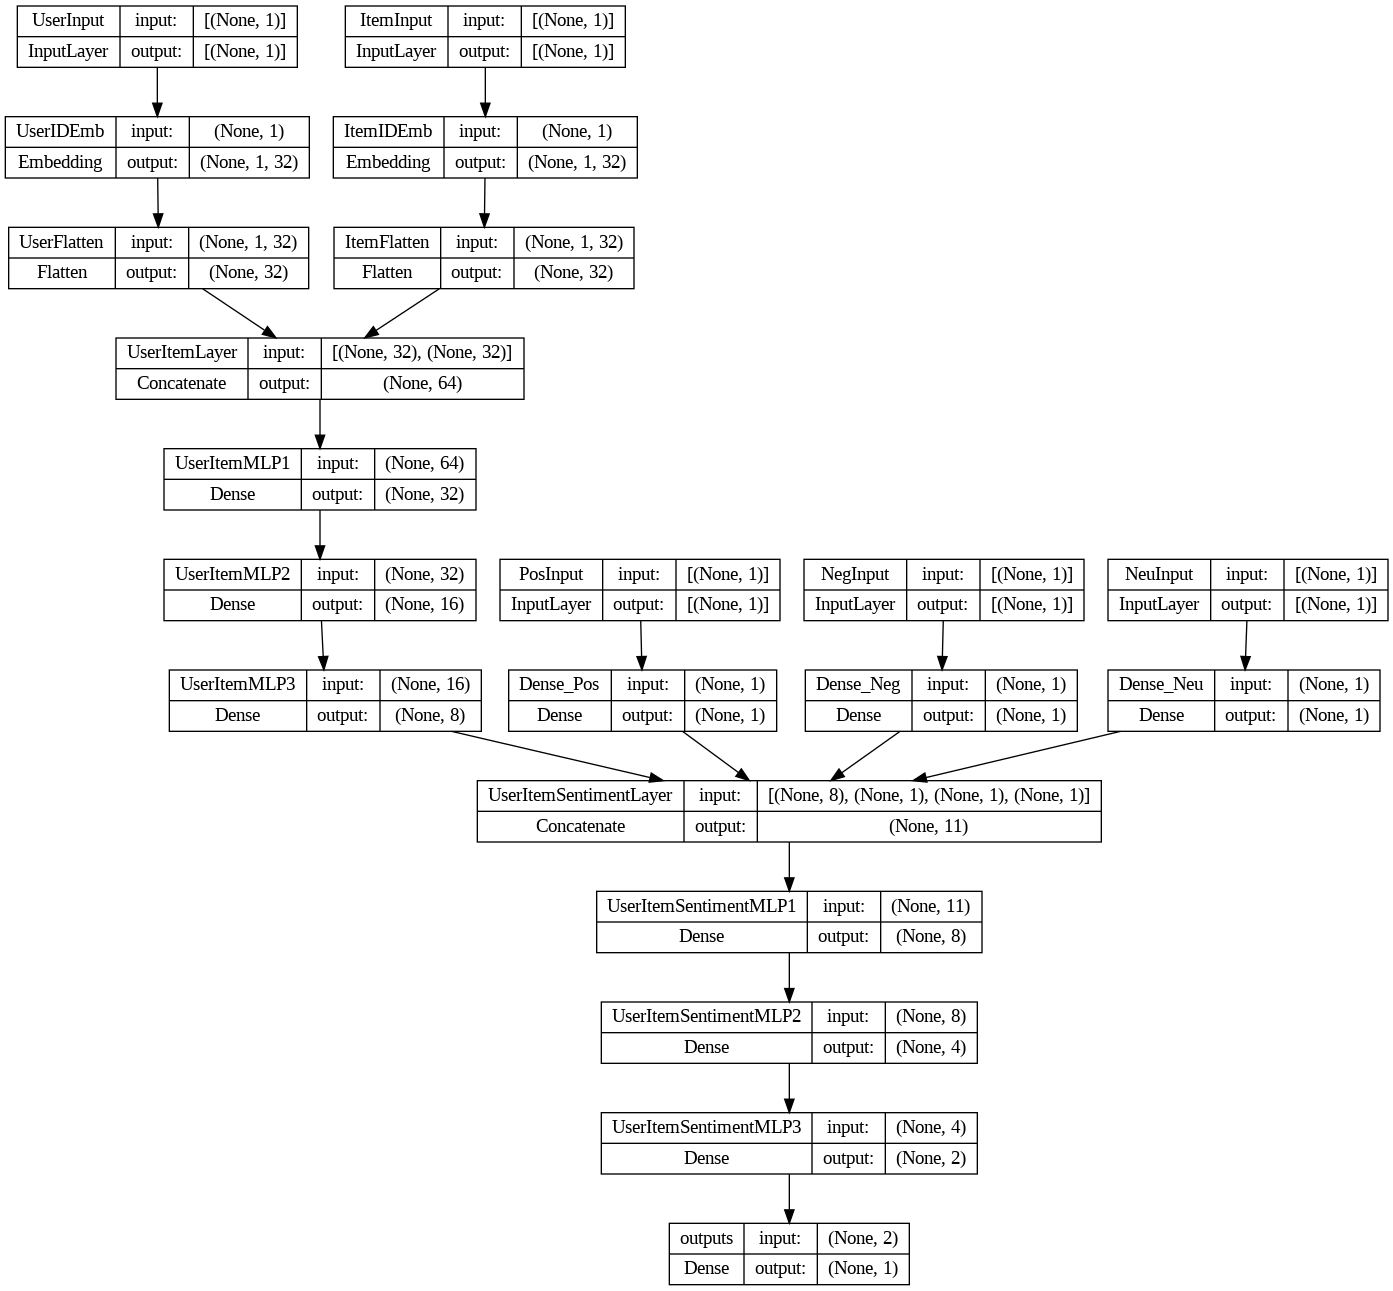

In [ ]:
model = ModelBuild(user_num = 281335, item_num = 59044, id_dims = 32, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)
plot_model(model, show_shapes=True, show_layer_names=True)

## Jihyeon:모든 파라미터에 대해 돌려보기
- id_dim = [256, 128, 64, 32]
- n layer = 3 고정
- layer_dim = [128, 64, 32, 16]
- lr = [0.0005, 0.0001, 0.005, 0.001]

- 5core userID num :  281887
- 5core movieID num :  59252
- 5core rating num :  3236784
- ----------
- 2core userID num :  297514
- 2core movieID num :  60085
- 2core rating num :  3300653
- ----------
- 10core userID num :  79542
- 10core movieID num :  30084
- 10core rating num :  1785734
- ----------
- 15core userID num :  33821
- 15core movieID num :  17410
- 15core rating num :  1115902
- ----------
- 20core userID num :  16221
- 20core movieID num :  9919
- 20core rating num :  701036
- ----------
- 30core userID num :  4335
- 30core movieID num :  3441
- 30core rating num :  279716

In [7]:
def model_run_param(id_dims, total_layer_dims,total_n_layer,lr):

    # param_embedding, param_layer_dim, param_lr = [],[],[]
    # MAE, RMSE = [], []
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)

    model = ModelBuild(user_num = user_num, item_num = item_num, id_dims = id_dims, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)

    adam = Adam(learning_rate=lr)
    model.compile(optimizer=adam, loss='binary_crossentropy')
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights = True)
    # model.summary()

    history = model.fit([train_set['userID'], train_set['movieID'], train_set['pos'], train_set['neg'], train_set['neu']],
                train_set['rating'],
                batch_size = 1024,
                epochs = 100,
                callbacks=[es],
                validation_data = ([valid_set['userID'], valid_set['movieID'],valid_set['pos'],valid_set['neg'],valid_set['neu'] ],
                valid_set['rating']))

    prediction = model.predict([test_set['userID'], test_set['movieID'], test_set['pos'], test_set['neg'], test_set['neu']])

    # normalize 안해도 되겠단 생각이..
    # prediction = 4 * norm(prediction) + 1
    prediction = 4 * prediction + 1

    MAE_temp = mean_absolute_error(test_set['rating'], prediction)
    RMSE_temp = mean_squared_error(test_set['rating'], prediction, squared = False)
    embedding_size = id_dims
    layer_dim = total_layer_dims
    lr = lr
    print(f'embedding:{embedding_size}, layer_dim:{layer_dim},lr:{lr}')
    print(f'MAE: {MAE_temp:.3f}')
    print(f'RMSE: {RMSE_temp:.3f}')

    # MAE.append(MAE_temp)
    # RMSE.append(RMSE_temp)
    # param_embedding.append(embedding_size)
    # param_layer_dim.append(layer_dim)
    # param_lr.append(lr)

    return MAE_temp, RMSE_temp, embedding_size, layer_dim, lr

In [ ]:
# 다시 시도...
'''
- 5core userID num :  281887
- 5core movieID num :  59252
- 5core rating num :  3236784
'''

user_num = 281887
item_num = 59252

id_dims = [128,64,32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [ 0.001,0.005]

### 실험1 - 5core

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
2213/2213 [==============================] - 35s 14ms/step - loss: 0.4309 - val_loss: 0.4083
Epoch 2/100
2213/2213 [==============================] - 20s 9ms/step - loss: 0.3802 - val_loss: 0.4072
Epoch 3/100
2213/2213 [==============================] - 18s 8ms/step - loss: 0.3518 - val_loss: 0.4206
Epoch 4/100
2213/2213 [==============================] - 19s 8ms/step - loss: 0.3146 - val_loss: 0.4534
Epoch 5/100
2213/2213 [==============================] - 18s 8ms/step - loss: 0.2778 - val_loss: 0.4978
Epoch 5: early stopping
20230/20230 [==============================] - 38s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.656
RMSE: 0.955
Epoch 1/100
2213/2213 [==============================] - 35s 14ms/step - loss: 0.4283 - val_loss: 0.4087
Epoch 2/100
2213/2213 [==============================] - 20s 9ms/step - loss: 0.3799 - val_loss: 0.4079
Epoch 3/100
2213/2213 [==============================] - 18s 8ms/step - loss: 0.3521 - val_loss: 0.4282
Epoch 4/100
2213/2213

In [ ]:
vader_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
vader_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.655716,0.954570
1,128,128,0.005,0.665624,0.958882
2,128,64,0.001,0.659312,0.956023
3,128,64,0.005,0.670035,0.961390
4,128,32,0.001,0.689334,0.968259
5,128,32,0.005,0.665515,0.959510
6,64,128,0.001,0.658032,0.954991
7,64,128,0.005,0.665552,0.957773
8,64,64,0.001,0.665199,0.959864
9,64,64,0.005,0.665941,0.960383


In [ ]:
# 결과 저장
vader_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-7-1.5coreVaderPolar_result.csv",index=False)


# n-core

- 2core userID num :  297514
- 2core movieID num :  60085
- 2core rating num :  3300653
- ----------
- 10core userID num :  79542
- 10core movieID num :  30084
- 10core rating num :  1785734
- ----------
- 15core userID num :  33821
- 15core movieID num :  17410
- 15core rating num :  1115902
- ----------
- 20core userID num :  16221
- 20core movieID num :  9919
- 20core rating num :  701036

### 10-core 실험

In [ ]:
# 10-core data load
# data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/10c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/10c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/10c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)


In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set


,userID,movieID,rating,compound,pos,neu,neg,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
653675,6127,10734,1.00,0.9937,0.433,0.514,0.053,1.14,11.36,2.27,7.95,14.77,2.27,4.55,17.05,3.41,19.32
1273428,21123,22756,0.75,0.8126,0.319,0.452,0.229,5.08,0.00,3.39,5.08,3.39,6.78,1.69,1.69,11.86,6.78
128409,77170,1563,0.00,-0.5106,0.193,0.501,0.306,12.00,4.00,8.00,8.00,8.00,8.00,4.00,8.00,12.00,8.00
511768,65119,7736,1.00,0.7579,0.484,0.516,0.000,0.00,9.09,0.00,0.00,0.00,0.00,0.00,9.09,0.00,9.09
1188111,14873,21264,1.00,0.8779,0.558,0.442,0.000,0.00,0.00,0.00,0.00,9.09,0.00,0.00,0.00,0.00,9.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745218,28884,13048,0.75,-0.2023,0.000,0.933,0.067,0.00,4.88,0.00,0.00,7.32,4.88,2.44,9.76,4.88,17.07
1147948,48579,20789,1.00,0.5859,0.792,0.208,0.000,0.00,50.00,0.00,0.00,50.00,0.00,0.00,50.00,0.00,50.00
546332,28099,8559,0.75,0.9612,0.438,0.562,0.000,3.23,12.90,0.00,6.45,9.68,0.00,3.23,9.68,6.45,12.90
47651,475,371,0.25,0.9937,0.472,0.498,0.030,1.20,9.64,2.41,1.20,10.84,1.20,1.20,13.25,3.61,21.69


In [ ]:
# 다시 시도...
'''
- 10core userID num :  79542
- 10core movieID num :  30084
- 10core rating num :  1785734
'''

user_num = 79542
item_num = 30084

id_dims = [128,64,32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001, 0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
1221/1221 [==============================] - 30s 22ms/step - loss: 0.4385 - val_loss: 0.4131
Epoch 2/100
1221/1221 [==============================] - 9s 8ms/step - loss: 0.3953 - val_loss: 0.4106
Epoch 3/100
1221/1221 [==============================] - 9s 8ms/step - loss: 0.3783 - val_loss: 0.4179
Epoch 4/100
1221/1221 [==============================] - 8s 7ms/step - loss: 0.3529 - val_loss: 0.4343
Epoch 5/100
1221/1221 [==============================] - 8s 7ms/step - loss: 0.3157 - val_loss: 0.4681
Epoch 5: early stopping
11161/11161 [==============================] - 20s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.646
RMSE: 0.930
Epoch 1/100
1221/1221 [==============================] - 25s 17ms/step - loss: 0.4332 - val_loss: 0.4141
Epoch 2/100
1221/1221 [==============================] - 9s 7ms/step - loss: 0.3955 - val_loss: 0.4112
Epoch 3/100
1221/1221 [==============================] - 9s 7ms/step - loss: 0.3786 - val_loss: 0.4221
Epoch 4/100
1221/1221 [====

In [ ]:
core10_df_final = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core10_df_final

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.646178,0.930251
1,128,128,0.005,0.653891,0.933183
2,128,64,0.001,0.659108,0.933236
3,128,64,0.005,0.659114,0.936594
4,128,32,0.001,0.705392,0.955426
5,128,32,0.005,0.675016,0.939613
6,64,128,0.001,0.650913,0.930731
7,64,128,0.005,0.656348,0.932903
8,64,64,0.001,0.662802,0.940344
9,64,64,0.005,0.653510,0.932379


In [ ]:
core10_df_final.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-7-1.10coreVaderPolar_result.csv",index=False)


### 15-core 실험

In [ ]:
# 15-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/15c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/15c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/15c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set


,userID,movieID,rating,compound,pos,neu,neg,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
931639,32594,15035,0.75,0.5994,0.197,0.667,0.136,5.77,5.77,2.88,5.77,5.77,2.88,3.85,10.58,9.62,13.46
448266,9454,7081,1.00,-0.9917,0.206,0.479,0.315,11.85,6.64,12.80,13.27,4.27,9.95,7.58,5.69,17.06,7.58
746392,26005,12529,1.00,0.7717,0.398,0.460,0.142,5.56,11.11,0.00,0.00,16.67,0.00,5.56,11.11,0.00,27.78
901694,11666,14638,1.00,0.8442,0.502,0.356,0.142,0.00,8.33,0.00,0.00,25.00,0.00,8.33,8.33,0.00,25.00
1075049,30611,16892,0.75,0.6597,0.730,0.270,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,25.00,25.00,25.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492494,15287,8121,1.00,0.9590,0.470,0.411,0.119,0.00,3.57,0.00,0.00,25.00,10.71,7.14,7.14,7.14,25.00
725400,9505,12174,0.75,0.4404,0.744,0.256,0.000,0.00,50.00,0.00,0.00,50.00,0.00,50.00,100.00,0.00,50.00
96848,26300,1326,0.75,0.9274,0.335,0.665,0.000,2.94,8.82,2.94,2.94,8.82,2.94,2.94,26.47,2.94,26.47
1011186,6816,16123,1.00,0.3612,1.000,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# 다시 시도...
'''
- 15core userID num :  33821
- 15core movieID num :  17410
- 15core rating num :  1115902
'''

user_num = 33821
item_num = 17410

id_dims = [128, 64,32]
total_layer_dims =  [128, 64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
763/763 [==============================] - 28s 32ms/step - loss: 0.4468 - val_loss: 0.4196
Epoch 2/100
763/763 [==============================] - 8s 10ms/step - loss: 0.4042 - val_loss: 0.4159
Epoch 3/100
763/763 [==============================] - 6s 7ms/step - loss: 0.3921 - val_loss: 0.4188
Epoch 4/100
763/763 [==============================] - 5s 7ms/step - loss: 0.3751 - val_loss: 0.4263
Epoch 5/100
763/763 [==============================] - 5s 7ms/step - loss: 0.3457 - val_loss: 0.4493
Epoch 5: early stopping
6975/6975 [==============================] - 13s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.641
RMSE: 0.917
Epoch 1/100
763/763 [==============================] - 23s 25ms/step - loss: 0.4384 - val_loss: 0.4196
Epoch 2/100
763/763 [==============================] - 7s 9ms/step - loss: 0.4046 - val_loss: 0.4165
Epoch 3/100
763/763 [==============================] - 6s 7ms/step - loss: 0.3922 - val_loss: 0.4188
Epoch 4/100
763/763 [=======================

In [ ]:
core15_df_final = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core15_df_final

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.641465,0.916713
1,128,128,0.005,0.651152,0.919603
2,128,64,0.001,0.649976,0.930144
3,128,64,0.005,0.662983,0.926623
4,128,32,0.001,0.731353,0.955593
5,128,32,0.005,0.667419,0.923970
6,64,128,0.001,0.643015,0.916303
7,64,128,0.005,0.650356,0.919364
8,64,64,0.001,0.643790,0.924594
9,64,64,0.005,0.654966,0.923341


In [ ]:
core15_df_final.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-7-1.15coreVaderPolar_result.csv",index=False)


### 20-core 실험

In [ ]:
# 20-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/20c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/20c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/20c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set


,userID,movieID,rating,compound,pos,neu,neg,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
391547,12873,6146,0.75,0.9337,0.244,0.587,0.169,8.70,2.61,10.43,11.30,6.09,6.09,1.74,5.22,17.39,10.43
188597,4104,2889,1.00,0.9501,0.324,0.676,0.000,0.00,18.92,0.00,2.70,18.92,2.70,5.41,16.22,0.00,27.03
69539,13121,984,0.50,0.9181,0.334,0.491,0.175,5.56,7.41,3.70,3.70,9.26,3.70,7.41,9.26,7.41,11.11
408837,12586,6406,0.25,-0.4019,0.000,0.816,0.184,15.38,7.69,7.69,0.00,0.00,7.69,0.00,0.00,23.08,0.00
518360,3801,7835,0.50,-0.9655,0.235,0.491,0.274,9.29,10.18,8.41,12.39,8.85,9.29,3.98,12.39,15.04,18.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618989,11796,9042,0.50,0.0000,0.000,1.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
523113,4904,7902,0.75,0.5267,0.379,0.474,0.147,0.00,15.38,7.69,0.00,7.69,0.00,0.00,7.69,7.69,15.38
8758,10511,125,0.75,0.6369,0.677,0.323,0.000,0.00,0.00,0.00,0.00,33.33,0.00,0.00,0.00,0.00,33.33
301539,5489,4525,0.25,-0.9212,0.146,0.663,0.191,3.72,4.19,3.72,9.30,3.26,6.51,4.19,3.26,9.30,6.05


In [ ]:
# 다시 시도...
'''
- 20core userID num :  16221
- 20core movieID num :  9919
- 20core rating num :  701036
'''

user_num = 16221
item_num = 9919

id_dims = [128, 64,32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
480/480 [==============================] - 27s 49ms/step - loss: 0.4634 - val_loss: 0.4285
Epoch 2/100
480/480 [==============================] - 5s 10ms/step - loss: 0.4187 - val_loss: 0.4247
Epoch 3/100
480/480 [==============================] - 4s 8ms/step - loss: 0.4101 - val_loss: 0.4251
Epoch 4/100
480/480 [==============================] - 5s 10ms/step - loss: 0.4007 - val_loss: 0.4268
Epoch 5/100
480/480 [==============================] - 4s 9ms/step - loss: 0.3856 - val_loss: 0.4381
Epoch 5: early stopping
4382/4382 [==============================] - 8s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.644
RMSE: 0.914
Epoch 1/100
480/480 [==============================] - 22s 37ms/step - loss: 0.4510 - val_loss: 0.4294
Epoch 2/100
480/480 [==============================] - 4s 9ms/step - loss: 0.4185 - val_loss: 0.4257
Epoch 3/100
480/480 [==============================] - 4s 8ms/step - loss: 0.4084 - val_loss: 0.4259
Epoch 4/100
480/480 [=======================

In [ ]:
core20_df_final = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core20_df_final

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.643788,0.913509
1,128,128,0.005,0.661708,0.916757
2,128,64,0.001,0.651742,0.923386
3,128,64,0.005,0.666383,0.922552
4,128,32,0.001,0.748067,0.958267
5,128,32,0.005,0.664261,0.922460
6,64,128,0.001,0.643699,0.910649
7,64,128,0.005,0.640744,0.914948
8,64,64,0.001,0.650774,0.922370
9,64,64,0.005,0.665596,0.921908


In [ ]:
core20_df_final.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-7-1.20coreVaderPolar_result.csv",index=False)


### 2-core 실험

In [ ]:
# 2-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/2c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/2c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/2c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set


,userID,movieID,rating,compound,pos,neu,neg,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
1601217,258079,33219,0.25,0.9409,0.246,0.607,0.148,3.14,2.52,2.52,3.14,3.14,2.52,1.26,3.77,8.81,13.21
2109928,267784,20408,0.50,-0.0314,0.319,0.414,0.267,16.67,8.33,0.00,16.67,8.33,8.33,8.33,8.33,25.00,8.33
1044096,213376,18340,1.00,0.6249,0.804,0.196,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
173120,61529,1914,1.00,0.3612,0.455,0.545,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2097197,228461,42684,0.50,0.7003,0.425,0.421,0.154,7.69,15.38,7.69,15.38,7.69,23.08,0.00,7.69,23.08,7.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15501,8927,132,1.00,0.4404,0.744,0.256,0.000,0.00,50.00,0.00,0.00,50.00,0.00,50.00,50.00,0.00,50.00
1977038,178288,40882,1.00,-0.8187,0.137,0.593,0.271,3.85,5.77,7.69,7.69,3.85,3.85,7.69,3.85,5.77,9.62
1438382,75224,29409,1.00,0.8555,0.356,0.644,0.000,0.00,10.00,0.00,5.00,10.00,0.00,5.00,15.00,0.00,20.00
2593677,238021,51001,1.00,0.4201,0.358,0.642,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# 다시 시도...
'''
- 2core userID num :  297514
- 2core movieID num :  60085
- 2core rating num :  3300653
'''

user_num = 297514
item_num = 60085

id_dims = [128,64,32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
2257/2257 [==============================] - 39s 16ms/step - loss: 0.4302 - val_loss: 0.4078
Epoch 2/100
2257/2257 [==============================] - 18s 8ms/step - loss: 0.3788 - val_loss: 0.4084
Epoch 3/100
2257/2257 [==============================] - 18s 8ms/step - loss: 0.3501 - val_loss: 0.4180
Epoch 4/100
2257/2257 [==============================] - 18s 8ms/step - loss: 0.3124 - val_loss: 0.4566
Epoch 4: early stopping
20630/20630 [==============================] - 37s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.686
RMSE: 0.964
Epoch 1/100
2257/2257 [==============================] - 34s 13ms/step - loss: 0.4277 - val_loss: 0.4084
Epoch 2/100
2257/2257 [==============================] - 18s 8ms/step - loss: 0.3779 - val_loss: 0.4101
Epoch 3/100
2257/2257 [==============================] - 18s 8ms/step - loss: 0.3495 - val_loss: 0.4242
Epoch 4/100
2257/2257 [==============================] - 18s 8ms/step - loss: 0.3165 - val_loss: 0.4564
Epoch 4: early stoppi

In [ ]:
core2_df_final = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core2_df_final

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.685638,0.963704
1,128,128,0.005,0.687245,0.965616
2,128,64,0.001,0.651424,0.958861
3,128,64,0.005,0.691910,0.969642
4,128,32,0.001,0.688190,0.974796
5,128,32,0.005,0.672292,0.963911
6,64,128,0.001,0.686230,0.964400
7,64,128,0.005,0.681336,0.965318
8,64,64,0.001,0.653299,0.958996
9,64,64,0.005,0.679138,0.964885


In [ ]:
core2_df_final.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-7-1.2coreVaderPolar_result.csv",index=False)



### 30-core 실험

In [ ]:
path = '/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/'

# 30-core
with open(path +'30c_Dense_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open(path +'30c_Dense_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open(path +'30c_Dense_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set


,userID,movieID,rating,compound,pos,neu,neg,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
25870,2304,379,1.00,0.4404,0.201,0.652,0.147,3.70,3.70,3.70,7.41,0.00,3.70,0.00,7.41,7.41,11.11
42281,3322,639,1.00,0.9001,0.571,0.429,0.000,0.00,0.00,0.00,0.00,15.38,0.00,7.69,15.38,0.00,15.38
184655,4156,2475,1.00,0.4777,0.175,0.718,0.107,1.59,1.59,1.59,3.17,0.00,1.59,1.59,6.35,4.76,3.17
122941,4146,1679,1.00,0.8550,0.199,0.649,0.152,4.23,6.88,2.65,4.76,5.29,5.29,4.23,7.94,6.88,12.17
260525,4001,3238,0.50,-0.5859,0.178,0.478,0.343,14.29,7.14,14.29,14.29,7.14,14.29,0.00,7.14,14.29,7.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205158,4247,2679,0.75,0.3400,0.188,0.714,0.097,0.00,7.69,0.00,0.00,7.69,0.00,7.69,7.69,7.69,15.38
78002,1412,1136,1.00,0.9688,0.287,0.618,0.095,2.38,7.14,2.38,5.95,3.57,1.19,3.57,8.33,2.38,9.52
267469,1549,3304,1.00,0.3818,0.783,0.217,0.000,0.00,33.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,66.67
25747,2413,371,0.75,0.5994,0.178,0.665,0.158,4.11,6.85,5.48,8.22,4.11,5.48,4.11,5.48,6.85,9.59


In [ ]:
# 다시 시도...
'''
- 30core userID num :  4335
- 30core movieID num :  3441
- 30core rating num :  279716
'''

user_num = 4335
item_num = 3441

id_dims = [128,64,32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
192/192 [==============================] - 29s 105ms/step - loss: 0.5194 - val_loss: 0.4662
Epoch 2/100
192/192 [==============================] - 4s 23ms/step - loss: 0.4593 - val_loss: 0.4605
Epoch 3/100
192/192 [==============================] - 3s 15ms/step - loss: 0.4532 - val_loss: 0.4585
Epoch 4/100
192/192 [==============================] - 3s 15ms/step - loss: 0.4484 - val_loss: 0.4584
Epoch 5/100
192/192 [==============================] - 2s 13ms/step - loss: 0.4433 - val_loss: 0.4586
Epoch 6/100
192/192 [==============================] - 1s 7ms/step - loss: 0.4369 - val_loss: 0.4615
Epoch 7/100
192/192 [==============================] - 1s 6ms/step - loss: 0.4272 - val_loss: 0.4655
Epoch 7: early stopping
1749/1749 [==============================] - 3s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.663
RMSE: 0.904
Epoch 1/100
192/192 [==============================] - 19s 78ms/step - loss: 0.4924 - val_loss: 0.4632
Epoch 2/100
192/192 [====================

In [ ]:
core30_df_final = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core30_df_final

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.662524,0.904013
1,128,128,0.005,0.666248,0.909720
2,128,64,0.001,0.669462,0.921514
3,128,64,0.005,0.658481,0.905639
4,128,32,0.001,0.809464,1.002997
5,128,32,0.005,0.687964,0.918458
6,64,128,0.001,0.652322,0.903056
7,64,128,0.005,0.654654,0.904751
8,64,64,0.001,0.657858,0.919698
9,64,64,0.005,0.666945,0.915140


In [ ]:
core30_df_final.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-7-1.30coreVaderPolar_result.csv",index=False)



### 7-core 실험

In [8]:
path = '/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/'

# 7-core
with open(path +'7c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set7 = pickle.load(f)
with open(path +'7c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set7 = pickle.load(f)
with open(path +'7c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set7 = pickle.load(f)

In [13]:
train_set = train_set7
valid_set = valid_set7
test_set = test_set7

In [14]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set


,userID,movieID,rating,compound,pos,neu,neg,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
936387,66143,16801,1.00,0.7737,0.341,0.659,0.000,0.00,6.67,0.00,6.67,13.33,6.67,0.00,6.67,0.00,20.00
1628375,95683,31172,0.00,-0.6654,0.242,0.447,0.311,7.14,9.52,9.52,7.14,9.52,14.29,4.76,14.29,19.05,23.81
284719,75105,4050,0.75,-0.1372,0.197,0.576,0.227,2.70,8.11,5.41,0.00,10.81,0.00,5.41,8.11,8.11,13.51
958536,111096,17423,0.50,0.9972,0.310,0.614,0.076,2.56,5.13,2.99,3.85,6.84,2.56,1.71,8.55,4.27,14.10
2415844,30849,43205,1.00,0.6249,0.451,0.549,0.000,0.00,16.67,0.00,16.67,0.00,16.67,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741112,1120,12165,1.00,0.7506,0.681,0.319,0.000,0.00,20.00,0.00,0.00,40.00,0.00,0.00,20.00,0.00,40.00
1888598,75825,35576,1.00,0.9042,0.466,0.534,0.000,0.00,22.22,5.56,0.00,22.22,0.00,11.11,27.78,0.00,27.78
7412,48078,49,1.00,0.4215,0.483,0.517,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
544635,81777,8483,1.00,0.8807,0.237,0.621,0.142,3.45,8.05,3.45,13.79,4.60,5.75,5.75,4.60,8.05,8.05


In [15]:
'''
- 7core userID num :  155242
- 7core movieID num :  44031
- 7core rating num :  2478320
'''

user_num = 155242
item_num = 44031

id_dims = [128, 64,32]
total_layer_dims =  [128, 64,32]
total_n_layer = 3
lr = [0.001, 0.005]

In [16]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
1695/1695 [==============================] - 40s 18ms/step - loss: 0.4341 - val_loss: 0.4101
Epoch 2/100
1695/1695 [==============================] - 12s 7ms/step - loss: 0.3874 - val_loss: 0.4084
Epoch 3/100
1695/1695 [==============================] - 12s 7ms/step - loss: 0.3646 - val_loss: 0.4172
Epoch 4/100
1695/1695 [==============================] - 11s 7ms/step - loss: 0.3314 - val_loss: 0.4446
Epoch 5/100
1695/1695 [==============================] - 11s 7ms/step - loss: 0.2930 - val_loss: 0.4879
Epoch 5: early stopping
15490/15490 [==============================] - 27s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.651
RMSE: 0.946
Epoch 1/100
1695/1695 [==============================] - 29s 15ms/step - loss: 0.4306 - val_loss: 0.4117
Epoch 2/100
1695/1695 [==============================] - 12s 7ms/step - loss: 0.3880 - val_loss: 0.4096
Epoch 3/100
1695/1695 [==============================] - 11s 7ms/step - loss: 0.3664 - val_loss: 0.4219
Epoch 4/100
1695/1695

In [17]:
core7_df_final = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core7_df_final

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.650901,0.945824
1,128,128,0.005,0.677408,0.951419
2,128,64,0.001,0.647466,0.943705
3,128,64,0.005,0.671403,0.948793
4,128,32,0.001,0.705860,0.962580
5,128,32,0.005,0.673198,0.949127
6,64,128,0.001,0.649920,0.944935
7,64,128,0.005,0.677037,0.949832
8,64,64,0.001,0.652712,0.947990
9,64,64,0.005,0.675648,0.955313


In [18]:
core7_df_final.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-7-1.7coreVaderPolar_result.csv",index=False)



# Positive, negative만_Model load

In [ ]:
def ModelBuild(user_num, item_num, id_dims, total_layer_dims, total_n_layer):
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)
    # user
    user_input = Input(shape=(1,), dtype='int32', name='UserInput')
    user_embedding = Embedding(user_num, id_dims, input_length=user_input.shape[1], name='UserIDEmb')(user_input)
    user_embedding = Flatten(name='UserFlatten')(user_embedding)

    # item
    item_input = Input(shape=(1,), dtype='int32', name='ItemInput')
    item_embedding = Embedding(item_num, id_dims, input_length=item_input.shape[1], name='ItemIDEmb')(item_input)
    item_embedding = Flatten(name='ItemFlatten')(item_embedding)


    # GMF
    # GMF = Multiply()([user_embedding, item_embedding])

    # MLP
    MLP_U_I = Concatenate(name='UserItemLayer')([user_embedding, item_embedding])

    for layer in conv_block(total_n_layer, total_layer_dims, 'UserItemMLP'):
        MLP_U_I = layer(MLP_U_I)


    # Sentiment
    pos_input = Input(shape=(1,), dtype='int32', name='PosInput')
    pos_dense = Dense(units=1, activation='relu', name='Dense_Pos')(pos_input)

    neg_input = Input(shape=(1,), dtype='int32', name='NegInput')
    neg_dense = Dense(units=1, activation='relu', name='Dense_Neg')(neg_input)

    # neu_input = Input(shape=(1,), dtype='int32', name='NeuInput')
    # neu_dense = Dense(units=1, activation='relu', name='Dense_Neu')(neu_input)

    # anticipation_input = Input(shape=(1,), dtype='int32', name='AnticipationInput')
    # anticipation_dense = Dense(units=1, activation='relu', name='Dense_Anticipation')(anticipation_input)

    # disgust_input = Input(shape=(1,), dtype='int32', name='DisgustInput')
    # disgust_dense = Dense(units=1, activation='relu', name='Dense_Disgust')(disgust_input)

    # fear_input = Input(shape=(1,), dtype='int32', name='FearInput')
    # fear_dense = Dense(units=1, activation='relu', name='Dense_Fear')(fear_input)

    # joy_input = Input(shape=(1,), dtype='int32', name='JoyInput')
    # joy_dense = Dense(units=1, activation='relu', name='Dense_Joy')(joy_input)

    # sadness_input = Input(shape=(1,), dtype='int32', name='SadnessInput')
    # sadness_dense = Dense(units=1, activation='relu', name='Dense_Sadness')(sadness_input)

    # surprise_input = Input(shape=(1,), dtype='int32', name='SurpriseInput')
    # surprise_dense = Dense(units=1, activation='relu', name='Dense_Surprise')(surprise_input)

    # trust_input = Input(shape=(1,), dtype='int32', name='TrustInput')
    # trust_dense = Dense(units=1, activation='relu', name='Dense_Trust')(trust_input)

    # Sentiment = Concatenate(name='SentimentLayer')([anger_dense, anticipation_dense, disgust_dense, fear_dense, joy_dense, sadness_dense, surprise_dense, trust_dense])
    # Sentiment concatenation
    MLP_U_I_S = Concatenate(name='UserItemSentimentLayer')([MLP_U_I, pos_dense, neg_dense])

    # Final concatenation
    # MLP_U_I_S = Concatenate(name='FinalLayer')([MLP_U_I, Sentiment])

    for layer in conv_block(total_n_layer, (total_layer_dims//(2**(total_n_layer-1))+8)//2, 'UserItemSentimentMLP'):
        MLP_U_I_S = layer(MLP_U_I_S)

    outputs = Dense(1, activation='sigmoid', name='outputs')(MLP_U_I_S)
    model = Model(inputs=[user_input, item_input, pos_input, neg_input ], outputs=outputs)
    return model

In [ ]:
def model_run_param(id_dims, total_layer_dims,total_n_layer,lr):

    # param_embedding, param_layer_dim, param_lr = [],[],[]
    # MAE, RMSE = [], []
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)

    model = ModelBuild(user_num = user_num, item_num = item_num, id_dims = id_dims, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)

    adam = Adam(learning_rate=lr)
    model.compile(optimizer=adam, loss='binary_crossentropy')
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights = True)
    # model.summary()

    history = model.fit([train_set['userID'], train_set['movieID'], train_set['pos'], train_set['neg']],
                train_set['rating'],
                batch_size = 1024,
                epochs = 100,
                callbacks=[es],
                validation_data = ([valid_set['userID'], valid_set['movieID'],valid_set['pos'],valid_set['neg']],
                valid_set['rating']))

    prediction = model.predict([test_set['userID'], test_set['movieID'], test_set['pos'], test_set['neg']])

    # normalize 안해도 되겠단 생각이..
    # prediction = 4 * norm(prediction) + 1
    prediction = 4 * prediction + 1

    MAE_temp = mean_absolute_error(test_set['rating'], prediction)
    RMSE_temp = mean_squared_error(test_set['rating'], prediction, squared = False)
    embedding_size = id_dims
    layer_dim = total_layer_dims
    lr = lr
    print(f'embedding:{embedding_size}, layer_dim:{layer_dim},lr:{lr}')
    print(f'MAE: {MAE_temp:.3f}')
    print(f'RMSE: {RMSE_temp:.3f}')

    # MAE.append(MAE_temp)
    # RMSE.append(RMSE_temp)
    # param_embedding.append(embedding_size)
    # param_layer_dim.append(layer_dim)
    # param_lr.append(lr)

    return MAE_temp, RMSE_temp, embedding_size, layer_dim, lr